In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import tarfile
import os
from bs4 import BeautifulSoup

# Sklearn library for metrics
from sklearn.metrics import accuracy_score, confusion_matrix

# Sklearn library for preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV

# Bag of words vectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline
import warnings

In [2]:
#Extract the spam tar.bz2 file and create a new directory containing the spam archive
tar = tarfile.open("./data/20021010_spam.tar.bz2", "r:bz2")  
tar.extractall("./data/spam_data")
tar.close()

In [3]:
# Extract the ham tar.bz2 file and create a new direcoty containing the ham archive
tar = tarfile.open("./data/20021010_hard_ham.tar.bz2", "r:bz2")  
tar.extractall("./data/ham_data")
tar.close()

In [4]:
def get_text(path):
    """Get the text of every mail in a given directory."""
    texts = []
    files = os.listdir(path)
    for file in files:
        with open(os.path.join(path, file), encoding='utf8', errors='ignore') as f:
            content = f.read()
            try:
                soup = BeautifulSoup(content, 'html.parser')
                content = soup.get_text()
            except:
                pass
        texts.append(content)
    return texts

In [5]:
# Get text from every document in spam
spam_path = './data/spam_data/spam'
spam_content = get_text(spam_path)

# Get text from every document in ham
ham_path = './data/ham_data/hard_ham'
ham_content = get_text(ham_path)

# Since there are just 250 ham elements let's choose just a 
spam_columns = 200
data = spam_content[0:spam_columns] + ham_content

In [6]:
# Transform the data
warnings.filterwarnings("ignore")

pipeline = Pipeline([
    ('bag', CountVectorizer()),
    ('frequencies', TfidfTransformer())
])

data = pipeline.fit_transform(data)

In [7]:
# Generate the labels before shuffling and splitting the data
labels = np.array([0 for _ in range(0, 200)] + [1 for _ in range(0, 250)])
print(labels.shape, data.shape)

(450,) (450, 33706)


In [8]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=1)

In [9]:
# Use grid search to choose the best parameters for the model
params = {
    'n_neighbors':[3, 4, 5],
    'weights':['uniform', 'distance']
}

# For the classification a KNN model will be used
KNN = KNeighborsClassifier()

grid = GridSearchCV(KNN, params, cv=2)
grid.fit(X_train, y_train)

grid.best_params_, grid.cv_results_

({'n_neighbors': 3, 'weights': 'distance'},
 {'mean_fit_time': array([0.00778604, 0.0078156 , 0.        , 0.00781512, 0.        ,
         0.        ]),
  'mean_score_time': array([0.00779068, 0.00783014, 0.01564562, 0.00781345, 0.01560843,
         0.0078156 ]),
  'mean_test_score': array([0.90277778, 0.91388889, 0.90277778, 0.91388889, 0.9       ,
         0.90833333]),
  'mean_train_score': array([0.975     , 1.        , 0.94722222, 1.        , 0.94166667,
         1.        ]),
  'param_n_neighbors': masked_array(data=[3, 3, 4, 4, 5, 5],
               mask=[False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_weights': masked_array(data=['uniform', 'distance', 'uniform', 'distance',
                     'uniform', 'distance'],
               mask=[False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'n_neighbors': 3, 'weights': 'uniform'},
   {'n_neighbors': 3, 'weights':

In [10]:
# Train and test the classifier
clf = KNeighborsClassifier(n_neighbors=3, weights='distance')
clf.fit(X_train, y_train)

predict = clf.predict(X_test)
conf_mx = confusion_matrix(y_test, predict)

print('Score --> {}'.format(accuracy_score(y_test, predict)))
print('Confusion Matrix --> {}'.format(conf_mx))

Score --> 0.9444444444444444
Confusion Matrix --> [[30  2]
 [ 3 55]]


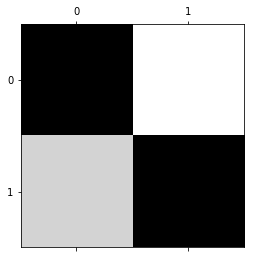

In [11]:
# Visualize the confusion matrix
row_sum = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sum
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()